# Import Packages

In [67]:
# Default packages
import os
from os.path import join
from datetime import date, datetime, timedelta

# Set current directory to "src"
os.chdir(join(os.getcwd(), os.pardir, "src"))
print(f"Current working directory: {os.getcwd()}")

# Installed packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from tqdm import tqdm

# Defined modules
from util.util import *

Current working directory: e:\Repositories\PCovNet\src


# Process Config

In [74]:
config = {
    'EXP_NAME': "RHR_plots",
    'EXP_PHASE': "phase1",
    'EXP_GROUP': "healthy",
}

In [75]:
# Dictionaries of dataset paths
DATA_DIR_DICT = {
    'phase1': join(os.getcwd(), os.pardir, "data", "raw", "phase1"),
    'phase2': join(os.getcwd(), os.pardir, "data", "raw", "phase2")
}
INFO_DIR_DICT = {
    'covid_phase1': join(os.getcwd(), os.pardir, "data", "external", "covid_phase1_info.csv"),
    'covid_phase2': join(os.getcwd(), os.pardir, "data", "external", "covid_phase2_info.csv"),
    'healthy_phase1': join(os.getcwd(), os.pardir, "data", "external", "healthy_phase1_info.csv"),
    'non-covid_phase1': join(os.getcwd(), os.pardir, "data", "external", "non-covid_phase1_info.csv"),
}

# Import subject info
subject_info = pd.read_csv(
    INFO_DIR_DICT[f"{config['EXP_GROUP']}_{config['EXP_PHASE']}"])


# Assign experiment directory
config['EXP_DIR'] = join(os.getcwd(), os.pardir, "experiment",
                         f"{config['EXP_NAME']}_{config['EXP_PHASE']}_{config['EXP_GROUP']}")
# timestamp = datetime.now().strftime(f"%Y-%m-%d %H-%M__")
# config['EXP_DIR'] = join(os.getcwd(), os.pardir, "experiment",
#                          timestamp + config['EXP_NAME'])
handle_dir(config['EXP_DIR'])


# Add DATA_DIR
config['DATA_DIR'] = DATA_DIR_DICT[config['EXP_PHASE']]


# Utility Method and Class

In [76]:
class Data():
    def __init__(self, config, data_info, index):
        self.config = config
        self.index = index
        self.exp_phase = self.config['EXP_PHASE']
        self.id = data_info['ID'][index]
        self.symptom_onset = pd.to_datetime(
            data_info['Symptom Onset'][index])
        self.date_dict = {
            'onset': self.symptom_onset,
            'before_7': self.symptom_onset + timedelta(days=-7),
            'before_10': self.symptom_onset + timedelta(days=-10),
            'before_20': self.symptom_onset + timedelta(days=-20),
            'after_21': self.symptom_onset + timedelta(days=21),
        }

        if self.exp_phase == 'phase1':
            self.device = 'Fitbit'
        elif self.exp_phase == 'phase2':
            self.device = data_info['Device'][index]

        self.__generate_data()

    def __generate_data(self):
        self.hr_path = os.path.join(self.config['DATA_DIR'],
                                    self.id + '_hr.csv')
        self.steps_path = os.path.join(self.config['DATA_DIR'],
                                       self.id + '_steps.csv')

        self.__get_hr()
        self.__get_steps()
        self.__get_rhr()
        self.__apply_filter(len_win=1600)


    def __get_hr(self):
        if self.exp_phase == 'phase1':
            self.hr = pd.read_csv(self.hr_path).set_index('datetime')
            self.hr.index.name = None
            self.hr.index = pd.to_datetime(self.hr.index)
            self.hr = self.hr.drop(
                self.hr.between_time("7:00", "00:00").index)

        elif self.exp_phase == 'phase2':
            self.hr = pd.read_csv(self.hr_path)
            self.hr['datetime'] = pd.to_datetime(
                self.hr['datetime'], errors='coerce')
            self.hr['datetime'] = self.hr['datetime'].apply(
                lambda t: t.replace(second=0))
            self.hr = self.hr.set_index('datetime')
            self.hr.index.name = None
            self.hr.drop(['Unnamed: 0'], axis=1, inplace=True)
            self.hr['heartrate'] = pd.to_numeric(
                self.hr['heartrate'], errors='coerce')
            self.hr = self.hr.dropna()
            self.hr = self.hr.drop(
                self.hr.between_time("7:00", "00:00").index)

    def __get_steps(self):
        if self.exp_phase == 'phase1':
            self.steps = pd.read_csv(self.steps_path).set_index('datetime')
            self.steps.index.name = None
            self.steps.index = pd.to_datetime(self.steps.index)
            self.steps = self.steps.drop(
                self.steps.between_time("7:00", "00:00").index)

        elif self.exp_phase == 'phase2':
            self.steps = pd.read_csv(self.steps_path)
            if self.device == 'AppleWatch':
                self.steps['start_datetime'] = pd.to_datetime(
                    self.steps['start_datetime'], errors='coerce')
                self.steps['datetime'] = self.steps['start_datetime']
            self.steps['datetime'] = pd.to_datetime(self.steps['datetime'])
            self.steps['datetime'] = self.steps['datetime'].apply(
                lambda t: t.replace(second=0))
            self.steps = self.steps.set_index('datetime')
            self.steps.index.name = None
            self.steps.drop(['Unnamed: 0'], axis=1, inplace=True)
            self.steps['steps'] = pd.to_numeric(
                self.steps['steps'], errors='coerce')
            self.steps = self.steps.dropna()
            self.steps = self.steps.drop(
                self.steps.between_time("7:00", "00:00").index)

    def __get_rhr(self):
        self.hr = self.hr.resample('1min').mean()
        self.steps = self.steps.resample('1min').sum()
        merged = pd.merge(self.hr, self.steps,
                          left_index=True, right_index=True)
        merged = merged.resample('1min').mean()
        merged = merged.dropna()
        # define RHR as the HR measurements recorded when there were zero steps taken
        # during a rolling time window of the preceding 12 minutes (including the current minute).
        merged['steps_window_12'] = merged['steps'].rolling(12).sum()
        self.rhr_raw = merged.loc[(merged['steps_window_12'] == 0)]
        self.rhr_raw = self.rhr_raw.drop(['steps', 'steps_window_12'], axis=1)
        self.rhr_raw = self.rhr_raw.rename(columns={"heartrate": "RHR"})

    def __apply_filter(self, len_win=400):
        self.rhr = self.rhr_raw.dropna()
        self.rhr = self.rhr.rolling(len_win).mean()
        self.rhr = self.rhr.resample('1H').mean()
        self.rhr = self.rhr.interpolate(method='linear')
        self.rhr = self.rhr.rolling(10).mean()
        self.rhr = self.rhr.dropna()

In [80]:
def rhr_plot(config, data_df, date_dict, title, ref="",
             save_plot=False, close_plot=False):

    plt.style.use('seaborn')
    plt.rcParams['font.family'] = "Arial"  # "Bahnschrift"
    plt.rcParams['figure.figsize'] = 15, 5

    data_df.index.name = 'datetime'
    data_df = data_df.reset_index()

    fig, ax = plt.subplots()

    ax.scatter(data_df['datetime'], data_df['RHR'], s=20,
               c='#003566',
               label='Resting Heart Rate')

    ax.axvline(date_dict['onset'],
               color='#d90429',
               label='Symptom Onset',
               linestyle='solid',
               lw=2,
               alpha=0.8)

    # Format x ticks
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')

    plt.xticks(rotation=90)

    # Plot info
    plt.title(title, fontsize=20, pad=38)
    plt.ylabel('Resting Heart Rate', fontsize=12, labelpad=15)
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), fontsize=12,
               loc="lower center", borderaxespad=0, ncol=5)
    # Set y-limit
    rhr_max = data_df['RHR'].max()
    rhr_min = data_df['RHR'].min()
    # plt.ylim((rhr_min if rhr_min < 50 else 50,
    #           rhr_max if (rhr_max > 120) else 120))

    if save_plot == True:
        plt.tight_layout()
        fig.savefig(f"{config['EXP_DIR']}/{ref}_rhr_plot.png",
                    bbox_inches='tight', dpi=300)

    if close_plot == True:
        plt.close()
    else:
        plt.show()

# Plot

#### Explore

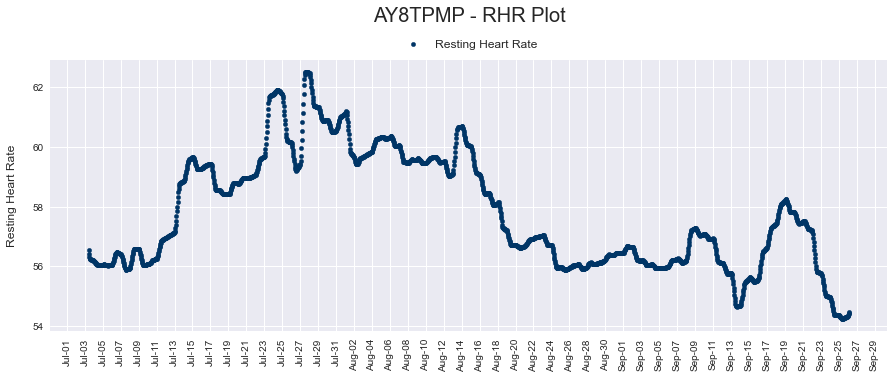

In [81]:
# Choose which data index from subject_info to run the experiment on
idx = 4
# Prepare data
data = Data(config=config, data_info=subject_info, index=idx)

rhr_plot(config, data.rhr, data.date_dict, title=f"{data.id} - RHR Plot",
         ref=f"{data.id} - RHR Plot", save_plot=False, close_plot=False)


#### Export All

In [82]:
# Choose which data index from subject_info to run the experiment on
for idx in tqdm(range(len(subject_info))):
    # Prepare data
    data = Data(config=config, data_info=subject_info, index=idx)

    rhr_plot(config, data.rhr, data.date_dict, title=f"{data.id} - RHR Plot", 
                ref=f"{data.id} - RHR Plot", save_plot=True, close_plot=True)


 17%|█▋        | 12/72 [00:19<01:34,  1.58s/it]Locator attempting to generate 1827 ticks ([10957.0, ..., 14609.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1827 ticks ([10957.0, ..., 14609.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1827 ticks ([10957.0, ..., 14609.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1827 ticks ([10957.0, ..., 14609.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1827 ticks ([10957.0, ..., 14609.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1827 ticks ([10957.0, ..., 14609.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1827 ticks ([10957.0, ..., 14609.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locato